# this script processes the political speeches. 

In [82]:
from datetime import datetime
from datetime import timedelta

td = timedelta (days = 0, hours = 0, minutes = 51)  
Anfang = datetime.now()
Start = Anfang + td

In [83]:
import csv
import pandas as pd
import os
from os import listdir
from os.path import isfile, join

import shelve
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [84]:
import liwc
import re
from collections import Counter

LIWC_dictionary= '/home/xhta/Robot/liwc/timeori.dic'
POSP_METADATA = '/home/xhta/Robot/proj/posp/posp_metadata.csv'
POSP_CLEANDATA = '/home/xhta/Robot/proj/posp/clean'

parse, cat_names = liwc.load_token_parser(LIWC_dictionary)

def tokenize(text):
    for match in re.finditer(r'\w+', text, re.UNICODE):
        yield match.group(0)

In [85]:
from string import punctuation
translator = str.maketrans(' ', ' ', punctuation)
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

In [86]:
import spacy
from spacy.lang.en import English
nlp = English()
nlp.add_pipe(nlp.create_pipe('sentencizer'))

from spacy.matcher import Matcher
nlp2 = spacy.load('en_core_web_sm')

from tp_utils import *

def normalize_text(doc):
    tokens = []
    for sent in doc.sents:
        sent = str(sent)
        sent = sent.replace('\r', ' ').replace('\n', ' ')
        lower = sent.lower()
        nopunc = lower.translate(translator)
        words = nopunc.split()
        nostop = [w for w in words if w not in stoplist]
        no_numbers = [w if not w.isdigit() else '#' for w in nostop]
        stemmed = [stemmer.stem(w) for w in no_numbers]
        tokens += stemmed
    return tokens

# read in metadata

In [87]:
dfmo = pd.DataFrame(index = range(0,0), columns=['jahr', 'leng', 'datum', 'speaker', 'nwords', 'ntoks', 'nverbs', 'npast', 'npresent', 'nfuture', 'nfpast', 'nfpresent', 'nffuture', 'doc'], dtype = int)
dfmo['datum'] = dfmo['datum'].astype('object')

with open (POSP_METADATA) as fcmo:
    readCSV = csv.reader(fcmo, delimiter = ';')
    next(readCSV, None)   # skip 1 line
    for Zei in readCSV:
        dfmo.loc[Zei[0]] = [0, 0, Zei[2], Zei[1], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

dfmo['doc'] = dfmo['doc'].astype('object')

In [88]:
fpath = POSP_CLEANDATA
ldir = listdir(fpath)

# fill the dataframe

In [89]:
i = 0
for fname in ldir:
    lae = len(fname)
    cname = fname[0:(lae-4)]
    rawtext = open(os.path.join(fpath, fname), "r").read()
    rawtext = rawtext.replace("\n", '')
    doc = nlp2(rawtext)
#
    dfmo.at[cname, 'nwords'] = len([token for token in doc if not token.is_punct])
    dfmo.at[cname, 'nverbs'] = len([w for w in list(doc) if w.tag_.startswith('V')])
#
    cltoks = normalize_text(doc)
    ntoks = [str(token).lower() for token in list(doc) if (not token.is_punct) & (not token.is_space) & (not token.is_stop) & (str(token) in cltoks)]
    dfmo.at[cname, 'ntoks'] = len(ntoks)
    #print("ntoks:", df.at[cnqame, 'ntoks'])
#
    laeng =  len(rawtext)
    dfmo.at[cname, 'leng'] = laeng
#
    tokens = tokenize(rawtext)
#
    dfmo.at[cname, 'doc'] =  rawtext
    npast, npresent, nfuture, antpast, antpresent, antfuture = spacy_parse(doc) #
    dfmo.loc[cname, 'npast'] = npast
    dfmo.loc[cname, 'npresent'] = npresent
    dfmo.loc[cname, 'nfuture'] = nfuture

    dfmo.loc[cname, 'antpast'] = antpast
    dfmo.loc[cname, 'antpresent'] = antpresent
    dfmo.loc[cname, 'antfuture'] = antfuture

    nfpast, nfpresent, nffuture, antfpast, antfpresent, antffuture = liwc_parse(rawtext)
#
    dfmo.loc[cname, 'nfpast'] = nfpast
    dfmo.loc[cname, 'nfpresent'] = nfpresent
    dfmo.loc[cname, 'nffuture'] = nffuture

    dfmo.loc[cname, 'antfpast'] = antfpast
    dfmo.loc[cname, 'antfpresent'] = antfpresent
    dfmo.loc[cname, 'antffuture'] = antffuture

    lse = nltk.sent_tokenize(rawtext)
    ldeont = 0
    lmodal = 0
    for j in range(len(lse)):
        ldeont += deont_parse(lse[j])
        lmodal += modal_parse(lse[j])
    dfmo.at[cname, "ldeont"] = ldeont
    dfmo.at[cname, "lmodal"] = lmodal
#
    if (i %19 == 0):
        je = datetime.now() + td
        pkl_fname = 'pj_demo_dfmo_full.' + je.strftime('%Y%m%d_%H%M%S' + ".pkl")
        print ("jetzt:{0}  i:{1} ... interim checkpointing to {2}".format(je, i, pkl_fname))
        dfmo.to_pickle(pkl_fname)
    i = i + 1

jetzt:2019-06-29 18:46:52.747367  i:0 ... interim checkpointing to pj_demo_dfmo_full.20190629_184652.pkl
jetzt:2019-06-29 18:50:55.597254  i:19 ... interim checkpointing to pj_demo_dfmo_full.20190629_185055.pkl
jetzt:2019-06-29 18:55:13.292553  i:38 ... interim checkpointing to pj_demo_dfmo_full.20190629_185513.pkl
jetzt:2019-06-29 18:58:44.257277  i:57 ... interim checkpointing to pj_demo_dfmo_full.20190629_185844.pkl
jetzt:2019-06-29 19:03:15.306470  i:76 ... interim checkpointing to pj_demo_dfmo_full.20190629_190315.pkl
jetzt:2019-06-29 19:09:11.046718  i:95 ... interim checkpointing to pj_demo_dfmo_full.20190629_190911.pkl
jetzt:2019-06-29 19:13:43.198628  i:114 ... interim checkpointing to pj_demo_dfmo_full.20190629_191343.pkl
jetzt:2019-06-29 19:17:52.398105  i:133 ... interim checkpointing to pj_demo_dfmo_full.20190629_191752.pkl
jetzt:2019-06-29 19:21:49.452239  i:152 ... interim checkpointing to pj_demo_dfmo_full.20190629_192149.pkl
jetzt:2019-06-29 19:26:29.102424  i:171 ... 

In [11]:
je = datetime.now() + td
pkl_fname = 'pj_demo_dfmo_full.' + je.strftime('%Y%m%d_%H%M%S' + ".pkl") 
print ("jetzt:{0}  i:{1} ... final checkpointing to {2}".format(je, i, pkl_fname))
dfmo.to_pickle(pkl_fname)

jetzt:2019-06-29 09:50:00.519322  i:251 ... final checkpointing to pj_demo_dfmo_full.20190629_095000.pkl


In [12]:
dfmo.head()

,jahr,leng,datum,speaker,nwords,ntoks,nverbs,npast,npresent,nfuture,...,nffuture,doc,antpast,antpresent,antfuture,antfpast,antfpresent,antffuture,ldeont,lmodal
M0001,0,13750,"April 25, 2007",McCain,2487,388,426,25,157,26,...,22,"\n\n""Today, I announce my candidacy for Presid...",0.120192,0.754808,0.125000,0.185185,0.733333,0.081481,0.0,1.0
M0002,0,18462,"May 1, 2007",McCain,3128,568,469,41,196,6,...,28,"\n""Since the dawn of our republic, Americans h...",0.168724,0.806584,0.024691,0.191558,0.717532,0.090909,0.0,17.0
M0003,0,17203,"May 21, 2007",McCain,2919,463,505,39,154,32,...,38,"\n\n""When our founding fathers signed the docu...",0.173333,0.684444,0.142222,0.136808,0.739414,0.123779,0.0,2.0
M0004,0,13528,"June 18, 2007",McCain,2461,417,427,159,82,11,...,28,"\n""Thank you, Admiral Stewart, Secretary Peter...",0.630952,0.325397,0.043651,0.496575,0.407534,0.095890,0.0,27.0
M0005,0,17127,"June 20, 2007",McCain,2820,457,432,30,188,17,...,38,"\n\n""It is pretty difficult for a politician t...",0.127660,0.800000,0.072340,0.163701,0.701068,0.135231,0.0,13.0


In [90]:
dfmo["speaker"].describe()

count       251
unique        2
top       Obama
freq        155
Name: speaker, dtype: object

In [91]:
dfmo.groupby("speaker").count()

,jahr,leng,datum,nwords,ntoks,nverbs,npast,npresent,nfuture,nfpast,...,nffuture,doc,antpast,antpresent,antfuture,antfpast,antfpresent,antffuture,ldeont,lmodal
speaker,,,,,,,,,,,,,,,,,,,,,
McCain,96,96,96,96,96,96,96,96,96,96,...,96,96,96,96,96,96,96,96,96,96
Obama,155,155,155,155,155,155,155,155,155,155,...,155,155,155,155,155,155,155,155,155,155


In [92]:
dfmo["lmodal"].describe()

count    251.000000
mean       7.326693
std        6.467522
min        0.000000
25%        3.000000
50%        6.000000
75%       10.000000
max       48.000000
Name: lmodal, dtype: float64

In [93]:
dfmo['lmodal'].groupby(dfmo["speaker"]).mean()

speaker
McCain    7.947917
Obama     6.941935
Name: lmodal, dtype: float64

In [94]:
from scipy.stats import ttest_ind, chisquare

In [95]:
dfmo.columns

Index(['jahr', 'leng', 'datum', 'speaker', 'nwords', 'ntoks', 'nverbs',
       'npast', 'npresent', 'nfuture', 'nfpast', 'nfpresent', 'nffuture',
       'doc', 'antpast', 'antpresent', 'antfuture', 'antfpast', 'antfpresent',
       'antffuture', 'ldeont', 'lmodal'],
      dtype='object')

In [96]:
dfmo['modal_ratio'] = dfmo['lmodal'] / dfmo['nwords']

In [97]:
dfmo_Obama = dfmo[ dfmo["speaker"] == 'Obama' ]

In [98]:
dfmo_McCain = dfmo[ dfmo["speaker"] == 'McCain' ]

In [99]:
len(dfmo_Obama), len(dfmo_McCain)

(155, 96)

In [100]:
# Obama vs McCain  usage of modal (would , could, might)
ttest_ind(dfmo_Obama['modal_ratio'], dfmo_McCain['modal_ratio'])

Ttest_indResult(statistic=-4.247398773921505, pvalue=3.0569451817810756e-05)

In [101]:
# past tense   Obama vs McCain
ttest_ind(dfmo_Obama['antpast'], dfmo_McCain['antpast'])

Ttest_indResult(statistic=0.5773462807578523, pvalue=0.5642272079428642)

In [102]:
# present tense   Obama vs McCain
ttest_ind(dfmo_Obama['antpresent'], dfmo_McCain['antpresent'])

Ttest_indResult(statistic=0.35528327634983004, pvalue=0.72267814920901)

In [103]:
# future tense   Obama vs McCain
ttest_ind(dfmo_Obama['antfuture'], dfmo_McCain['antfuture'])

Ttest_indResult(statistic=-1.6188090516772249, pvalue=0.10675425396364378)

In [104]:
dfmo.groupby("speaker").mean()

,jahr,leng,nwords,ntoks,nverbs,npast,npresent,nfuture,nfpast,nfpresent,nffuture,antpast,antpresent,antfuture,antfpast,antfpresent,antffuture,ldeont,lmodal,modal_ratio
speaker,,,,,,,,,,,,,,,,,,,,
McCain,0.0,12600.781250,2215.093750,368.416667,379.791667,43.635417,133.31250,21.645833,53.562500,174.739583,35.208333,0.209524,0.677362,0.113114,0.199057,0.665530,0.135413,0.0,7.947917,0.003425
Obama,0.0,15236.522581,2807.477419,465.916129,518.703226,60.761290,191.43871,29.451613,74.154839,244.929032,42.548387,0.216861,0.681271,0.101868,0.207882,0.678454,0.113664,0.0,6.941935,0.002330


In [105]:
# McCain, POS tagging, i.e. antpast, antpresent, antfuture,  chisquare : observed vs expected
chisquare([21, 68, 11], [33, 33, 34])

Power_divergenceResult(statistic=57.04367201426025, pvalue=4.103212493030197e-13)

In [106]:
# Obama, POS tagging, i.e. antpast, antpresent, antfuture,  chisquare : observed vs expected
chisquare([22, 28, 10], [33, 33, 34])

Power_divergenceResult(statistic=21.36541889483066, pvalue=2.2938141908821448e-05)

In [107]:
# McCain, LIWC, i.e. antfpast,antfpresent, antffuture,  chisquare : observed vs expected
chisquare([20, 67, 13], [33, 33, 34])

Power_divergenceResult(statistic=53.12210338680927, pvalue=2.9152903563929526e-12)

In [108]:
# Obama, LIWC, i.e. antfpast,antfpresent, antffuture,  chisquare : observed vs expected
chisquare([21, 68, 11], [33, 33, 34])

Power_divergenceResult(statistic=57.04367201426025, pvalue=4.103212493030197e-13)

In [109]:
dfmo.loc["M0001", "doc"]

'"Today, I announce my candidacy for President of the United States. I do so grateful for the privileges this country has already given me; mindful that I must seek this responsibility for reasons greater than my self-interest; and determined to use every lesson I\'ve learned through hard experience and the history I\'ve witnessed, every inspiration I\'ve drawn from the patriots I\'ve known and the faith that guides me to meet the challenges of our time, and strengthen this great and good nation upon whom all mankind depends."We\'ve begun another campaign season earlier than many Americans prefer. So soon after our last contentious election, our differences are again sure to be sharpened and exaggerated. That\'s the nature of free elections. But even in the heat of a campaign, we shouldn\'t lose sight that much more defines us than our partisanship; much more unites us than divides us. We have common purposes and common challenges, and we live in momentous times. This election should b

# do the plots

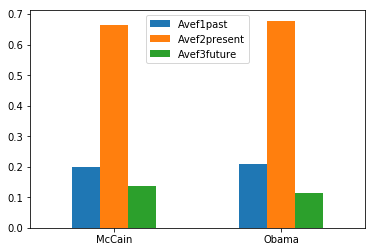

In [112]:
#focus  liwc
for inde in dfmo.index:
   dfmo.loc[inde, 'totf'] = dfmo.loc[inde, 'nfpast'] + dfmo.loc[inde, 'nfpresent'] + dfmo.loc[inde, 'nffuture']
   dfmo.loc[inde, 'antfpast'] = dfmo.loc[inde, 'nfpast'] / dfmo.loc[inde, 'totf']
   dfmo.loc[inde, 'antfpresent'] = dfmo.loc[inde, 'nfpresent'] / dfmo.loc[inde, 'totf']
   dfmo.loc[inde, 'antffuture'] = dfmo.loc[inde, 'nffuture'] / dfmo.loc[inde, 'totf']

oAvefpast = dfmo.loc[ dfmo['speaker'] == 'Obama', 'antfpast'].mean()
oAvefpresent = dfmo.loc[ dfmo['speaker'] == 'Obama', 'antfpresent'].mean()
oAveffuture = dfmo.loc[ dfmo['speaker'] == 'Obama', 'antffuture'].mean()

mAvefpast = dfmo.loc[ dfmo['speaker'] == 'McCain', 'antfpast'].mean()
mAvefpresent = dfmo.loc[ dfmo['speaker'] == 'McCain', 'antfpresent'].mean()
mAveffuture = dfmo.loc[ dfmo['speaker'] == 'McCain', 'antffuture'].mean()

modfplot = pd.DataFrame({'Avef1past' : [mAvefpast, oAvefpast], 'Avef2present': [mAvefpresent, oAvefpresent], 'Avef3future': [mAveffuture, oAveffuture]}, index = ['McCain', 'Obama'] )
modfplot.plot.bar(rot=0)
plt.show()

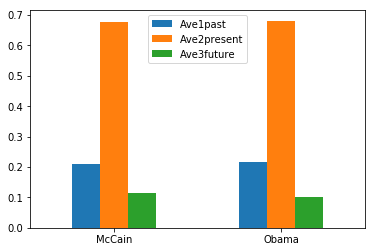

In [113]:
# POS taggging spacy
oAvepast = dfmo.loc[ dfmo['speaker'] == 'Obama', 'antpast'].mean()
oAvepresent = dfmo.loc[ dfmo['speaker'] == 'Obama', 'antpresent'].mean()
oAvefuture = dfmo.loc[ dfmo['speaker'] == 'Obama', 'antfuture'].mean()

mAvepast = dfmo.loc[ dfmo['speaker'] == 'McCain', 'antpast'].mean()
mAvepresent = dfmo.loc[ dfmo['speaker'] == 'McCain', 'antpresent'].mean()
mAvefuture = dfmo.loc[ dfmo['speaker'] == 'McCain', 'antfuture'].mean()

modtplot = pd.DataFrame({'Ave1past' : [mAvepast, oAvepast], 'Ave2present': [mAvepresent, oAvepresent], 'Ave3future': [mAvefuture, oAvefuture]}, index = ['McCain', 'Obama'] )
modtplot.plot.bar(rot=0, sort_columns=False)
plt.show()